In [1]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt
modelPath = "C:/Users/yuanZ/.llama/checkpoints/Llama3.1-8B"
tokenizer_path = "C:/Users/yuanZ/.llama/checkpoints/Llama3.1-8B/tokenizer.model"
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

tokenizer.decode(tokenizer.encode("hello world!"))

'hello world!'

In [2]:
model = torch.load(modelPath+"/consolidated.00.pth")
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [3]:
with open(modelPath+"/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'ffn_dim_multiplier': 1.3,
 'multiple_of': 1024,
 'n_heads': 32,
 'n_kv_heads': 8,
 'n_layers': 32,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0,
 'use_scaled_rope': True,
 'vocab_size': 128256}

In [4]:
# use exactly the same structure
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

In [144]:
prompt = "Your father's mother is grandma, and your father's father is "
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)


[128000, 7927, 7126, 596, 6691, 374, 83777, 11, 323, 701, 7126, 596, 7126, 374, 220]
['<|begin_of_text|>', 'Your', ' father', "'s", ' mother', ' is', ' grandma', ',', ' and', ' your', ' father', "'s", ' father', ' is', ' ']


In [149]:
device = torch.device("cuda:0")
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized = token_embeddings_unnormalized.to(device)
print(token_embeddings_unnormalized.device)
print(token_embeddings_unnormalized.shape)

cuda:0
torch.Size([15, 4096])


In [150]:
def rms_norm(tensor, norm_weight):
    return (tensor* torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weight

In [151]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
token_embeddings.shape

torch.Size([15, 4096])

In [152]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


In [153]:
# unwrap the queries from multiheads; 32*128 * 4096  ; 32 head, 128 query vector size, 4096 embeddeing dim;
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
q_layer0.shape

torch.Size([32, 128, 4096])

In [154]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

In [155]:
#q_weight * token = q
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape
#19 token and 120 length query;

torch.Size([15, 128])

In [156]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

#splite the vector into pairs so that apply rope

torch.Size([15, 64, 2])

In [157]:
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [158]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

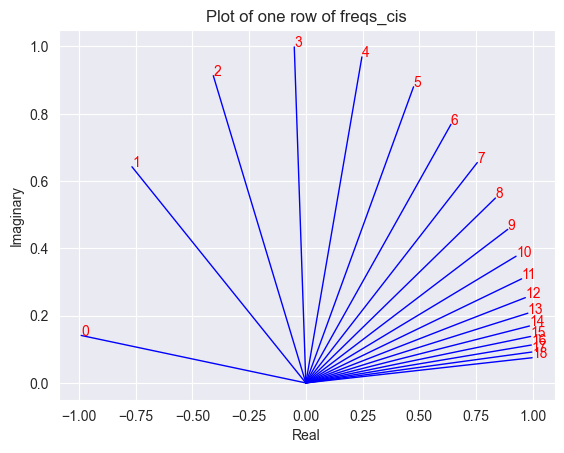

In [159]:

freqs_for_each_token = torch.outer(torch.arange(19), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# viewing tjhe third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:19]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

In [160]:
# now we have compex number for each elements position
# torch.Size([19, 64, 2]) => [19,64]
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([15, 64])

In [162]:
# add the rope information
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis.to(device)
q_per_token_as_complex_numbers_rotated.shape

torch.Size([15, 64])

In [163]:
#then view the compex number as two real number
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

torch.Size([15, 64, 2])

In [164]:
#pair merged for dim change from 64 back to 128
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([15, 128])

In [165]:
#key are the same: but with 1/4 less weights since the weight for keys are shared across 4 heads at a time
k_layer0 = model["layers.0.attention.wk.weight"]
print(k_layer0.shape)
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0]// n_kv_heads, dim)
k_layer0.shape

torch.Size([1024, 4096])


torch.Size([8, 128, 4096])

In [166]:
# first layer first head as exp:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [167]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([15, 128])

In [168]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

torch.Size([15, 64, 2])

In [169]:
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

torch.Size([15, 64])

In [171]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis.to(device))
k_per_token_split_into_pairs_rotated.shape

torch.Size([15, 64, 2])

In [172]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape

torch.Size([15, 128])

In [173]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([15, 15])

C:\Users\yuanZ\AppData\Local\Temp\ipykernel_29984\3274468530.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im, ax=ax)


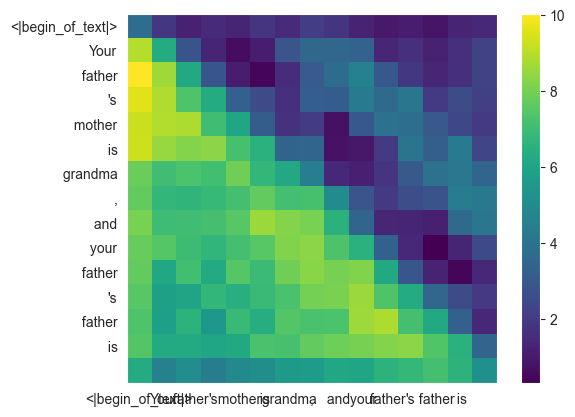

In [174]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    ax.grid(False)  # Disable the grid to prevent the warning

    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')

    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)

    ax.figure.colorbar(im, ax=ax)

display_qk_heatmap(qk_per_token.to('cpu'))


In [175]:
# currently each token will pay more attention to previous, but also have attenthion to future; then we need mask
mask = torch.full((len(tokens), len(tokens)), float('-inf'), device=tokens.device )
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0.,

C:\Users\yuanZ\AppData\Local\Temp\ipykernel_29984\3274468530.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im, ax=ax)


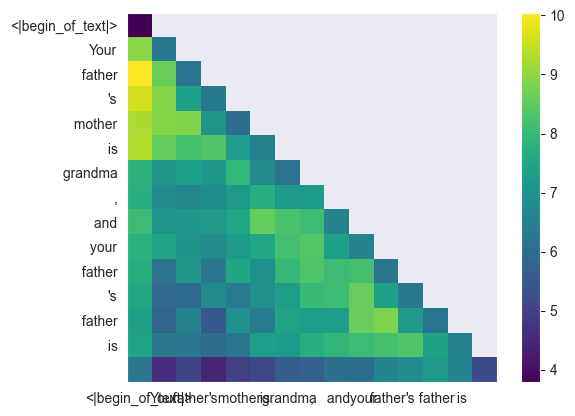

In [176]:
qk_per_token_after_masking = qk_per_token.to('cpu') + mask
display_qk_heatmap(qk_per_token_after_masking)

C:\Users\yuanZ\AppData\Local\Temp\ipykernel_29984\3274468530.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im, ax=ax)


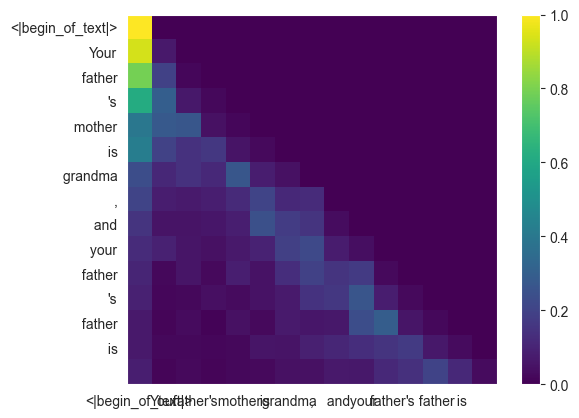

In [177]:
# after softmax
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

In [178]:
# value vector also have 8 head since each 4 attention heads share the same weight:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape

torch.Size([8, 128, 4096])

In [179]:
# fist layer first head:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 4096])

In [180]:
#Vweight* token = V
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([15, 128])

In [181]:
#finnal attention value for first layer first head:
# 19X19   *  19X128 => 19X128
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token.to('cpu'))
qkv_attention.shape

torch.Size([15, 128])

In [182]:
# do the exactly same math for the first layer 32 head;
device = torch.device('cuda:0')
qkv_attention_store = []
token_embeddings = token_embeddings.to(device)
for head in range(n_heads):
    q_layer0_head = q_layer0[head].to(device)
    k_layer0_head = k_layer0[head//4].to(device) # 4 heads share the same weights
    v_layer0_head = v_layer0[head//4].to(device)
    # step 1, get the vector:
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T) #[19,128]
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)
    # step 2, add the rppe for q and k:
    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2) #[19,64,2]
    q_per_token_split_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs) #[19,64]
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_split_as_complex_numbers * freqs_cis[:len(tokens)].to(device) ) #[19,64,2]
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)  # [19,128]

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_split_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_split_as_complex_numbers * freqs_cis[:len(tokens)].to(device) )
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    # step 3, get qk matrix
    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5  # 19X128 * 128*19 = 19*19

    #step 4 add mask, softmax
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1).to(device)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)

    #step 5, get the attention's output value
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token) # 19X19 * 19X128 = 19X128
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

In [183]:
qkv_attention_store[1].shape # we have 32 heads, in each, we have 19*128 matrix

torch.Size([15, 128])

In [184]:
# then we concate them into a large matrix as [19, 32*128]
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([15, 4096])

In [185]:
#multiply the attention with weight matrix:
w_layer0 = model["layers.0.attention.wo.weight"].to(device)
print(w_layer0.shape)
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([4096, 4096])


torch.Size([15, 4096])

In [186]:
#this is the output of the self-attention head moduel, which will add to the original embeded token and norm
embedding_after_edit = token_embeddings_unnormalized.to(device) + embedding_delta
print(embedding_after_edit.shape)
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"].to(device))
embedding_after_edit_normalized.shape

torch.Size([15, 4096])


torch.Size([15, 4096])

In [187]:
# then the edit x will input into FFN, in LlaMA, we use SwiGLU FFN
w1 = model["layers.0.feed_forward.w1.weight"].to(device)
w2 = model["layers.0.feed_forward.w2.weight"].to(device)
w3 = model["layers.0.feed_forward.w3.weight"].to(device)
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape
#finnaly we get the output of the first layer encoder!

torch.Size([15, 4096])

In [190]:
final_embedding = token_embeddings_unnormalized.to(device)
device = torch.device('cuda:0')
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis.to(device))
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis.to(device))
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1).to(device)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

In [191]:
final_embedding = rms_norm(final_embedding, model["norm.weight"])
final_embedding.shape

torch.Size([15, 4096])

In [192]:
# decode:
model["output.weight"].shape

torch.Size([128256, 4096])

In [193]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

In [196]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(4194, device='cuda:0')

In [195]:
tokenizer.decode([next_token.item()])

'\xa0'